In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, sys

In [74]:
csv_input_path = os.path.join(os.environ["git"], "sleep_study", "trimmed_result.csv")

In [75]:
csv_input_path

'C:\\Users\\taiki\\git\\sleep_study\\trimmed_result.csv'

In [90]:
df = pd.read_table(csv_input_path)

In [104]:
# replace のindex [0 ~ 0-.5]の部分をaccuracyで置き換える
np_table = df.to_numpy()

10 133


In [121]:
# 1. 2n(from 2)の先頭5個分の要素を後半5個分に移動する 
# 2. 2n-1(from 1)の5個分の要素を2n(from 2)まで置き換える
row, col = np_table.shape
for __col in range(2, col, 2):
    # 1
    np_table[5:, __col] = np_table[:5, __col]
    # 2
    np_table[:5, __col] = np_table[:5, __col - 1]


In [424]:
# csv出力
output_path = os.path.join(os.environ["git"], "sleep_study", "output_for_ave_and_var.csv")
np.savetxt(output_path, np_table, delimiter=",", fmt="%.8f")


In [472]:
# acc, replaced を縦に結合する
acc_array = np.array([])
rep_array = np.array([])
for __col in range(col):
    if __col % 2 == 0:
        rep_array = np.append(rep_array, np_table[:, __col])
    else:
        acc_array = np.append(acc_array, np_table[:, __col])

In [528]:
# 行方向にスタックされているので整形
acc_array = acc_array.reshape(66, 10)
rep_array = rep_array.reshape(67, 10)
# uncertainty の要素を削除
rep_array = np.delete(rep_array, 0, 0)

In [536]:
# 水平方向に結合
new_table = np.hstack((acc_array, rep_array))

In [545]:
# csv出力
output_path = os.path.join(os.environ["git"], "sleep_study", "output_for_ave_and_var_ver2.csv")
np.savetxt(output_path, new_table, delimiter=",", fmt="%.8f")


In [1]:
# csv を wandb にアップロードしてグラフをいい感じに作成する
# import wandb
import pandas as pd
import sys, os
import numpy as np

In [2]:
filepath = os.path.join(os.environ["git"], "sleep_study", "output_for_ave_and_var_ver2.csv")

In [3]:
df = pd.read_csv(filepath, header=0)

In [4]:
df.shape

(68, 20)

In [5]:
table = df.to_numpy()

In [52]:
# l = list()
# for i in range(int(table.shape[0]/3)):
#     l.append(table[i * 3, 0])

In [6]:
# positive, base の比較のテストコード
# table[0]
acc_base = table[:, :10]
acc_pos = table[:, 10:]
# 縦方向に 結合
acc_base = acc_base.reshape(-1)
acc_pos = acc_pos.reshape(-1)
# さらに縦に結合
acc_array = np.hstack([acc_base, acc_pos])
# 先頭の680個は"base", 後半は"sub"
model_header = ["base"] * 680 + ["proposed"] * 680
# 不確かさは0.1 - 0.9を136回繰り返す
unc_header = [i * 0.1 + 0.1 for i in range(10)] * 136
# DataFrame作成
customed_df = pd.DataFrame({"uncertainty":unc_header, "model": model_header, "accuracy": acc_array})

In [ ]:

# 被験者ループ
# for i in range(acc_base.shape[0]):
#     wandb.init(project="test", name="unc_acc_test")
#     for j in range(10):
#         wandb.log({"unc": j*0.1, "base_acc":acc_base[i][j], "pos_acc""positive_acc":acc_pos[i][j]})
#     wandb.finish()

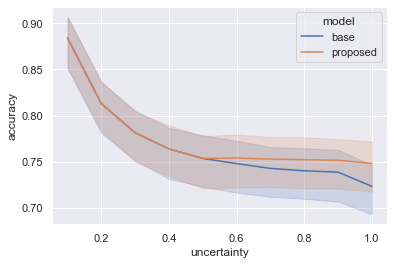

In [7]:
# seaborn による出力
import seaborn as sns
sns.set_theme(style="darkgrid")

# Load an example dataset with long-form data
fmri = sns.load_dataset("fmri")

# Plot the responses for different events and regions
line_plot = sns.lineplot(x="uncertainty", y="accuracy", hue="model", data=customed_df)
figure = line_plot.get_figure()
# 保存先を指定
save_path = "tmp.png"
figure.savefig(save_path)

In [1]:
# fftによる周波数解析
import numpy as np
import pandas as pd
import os
from scipy.signal import hamming
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import DataFrame
from fractions import Fraction
from tqdm import tqdm

# データの読み込み
filepath = os.path.join(os.environ["git"], "sleep_study", "emfit_20200817180705_trimed.csv")
df = pd.read_csv(filepath, usecols=["Date", "Time", " Heart Rate"])

In [2]:
# fftの計算を行う
def calc_fft(df: DataFrame, window_len: int, has_window: bool) -> tuple:
    # 窓関数をかけるかどうか
    if has_window:
        amped = hamming(window_len) * df[" Heart Rate"][:window_len]
    else:
        amped = df[" Heart Rate"][:window_len]
    fft = np.fft.fft(amped) / (len(df) / 2.0)
    log_fft = 20 * np.log10(np.abs(fft))
    return amped, np.abs(fft), log_fft, None
    
# グラフを並べて表示する 
def plot_images(images_arr, window_len: int, disp_num: int = 10, disp_start: int = 1, minute: int = 0):
    sns.set()
    fig, axes = plt.subplots(1, len(images_arr), figsize=(4*len(images_arr), 5))
    axes = axes.flatten()
    for i, (img, ax) in enumerate(zip(images_arr, axes)):
        if i > 1:
            # fs = 1
            N = window_len
            # delta_f = fs / N
            # l = [delta_f * j for j in range(disp_len)]
            l = [N / j / 60 for j in range(disp_start, disp_num, 1)]
            ax.plot(l, img)
            ax.scatter(l, img)
            ax.set_xlabel("Time[m]")
            # ax.set_ylabel("strength")
            # 表示メモリを設定
            ax.set_xticks(l[:3])
            # ax.set_xticks([0, minute/2, minute])
            # 最大値の設定（表示領域を0m~120mに絞るため）
            ax.set_xlim(0, minute)
        else:
            ax.plot(img)
            ax.set_xlabel("Sample")
        # ax.axis("off")
    plt.tight_layout()

# 対数グラフのみを並べて表示する 
def plot_log_images(images_arr, window_len: int, disp_num: int = 10, disp_start: int = 1, minutes: list = []):
    sns.set()
    fig, axes = plt.subplots(4, 8, figsize=(32, 16))
    # NOTE: img, ax のループの際は行方向の分割しか行わないので、列方向には分割する必要がある
    for i, (_, ax) in enumerate(zip(minutes, axes)):
        for k in range(8):
            # print(ax)
            if 8 * i + k < 31:
                l = [60 * minutes[8 * i + k] / j / 60 for j in range(disp_start, disp_num, 1)]
                ax[k].plot(l, images_arr[8 * i + k])
                ax[k].scatter(l, images_arr[8 * i + k])
                ax[k].set_xlabel("Time[m]")
                # 表示メモリを設定
                ax[k].set_xticks(l[:3])
                # 最大値の設定（表示領域を0m~120mに絞るため）
                ax[k].set_xlim(0, minutes[8 * i + k])

    plt.tight_layout()

100%|██████████| 31/31 [00:00<00:00, 1098.44it/s]


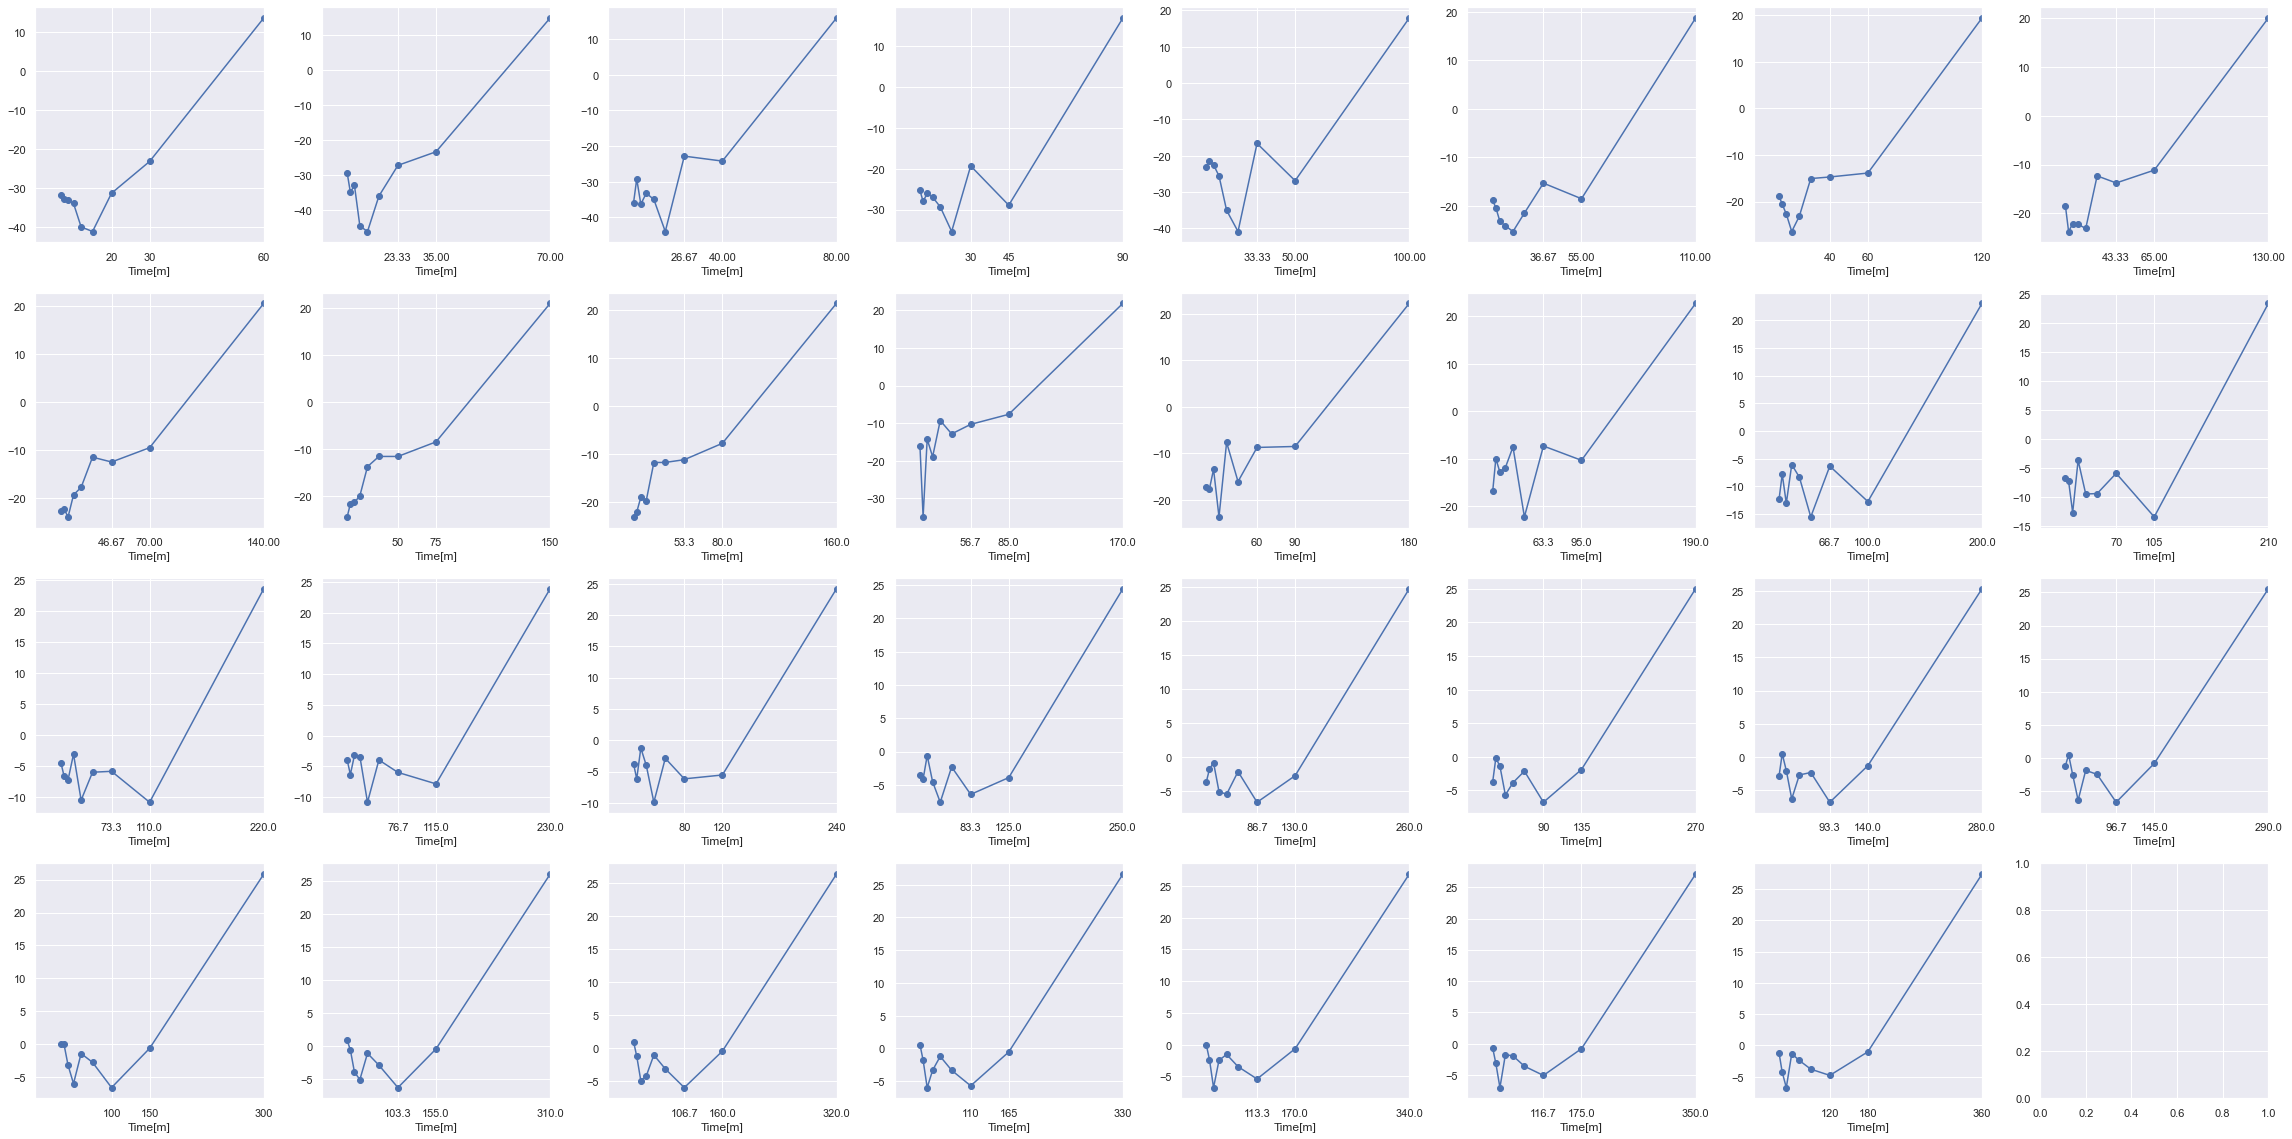

In [3]:
# NOTE: 先生の意向により対数グラフのみを並べて表示
minutes = [i for i in range(60, 370, 10)]
log_ffts = list()
for minute in tqdm(minutes):
    disp_num = 10
    disp_start = 1
    _, _, log_fft, _ = calc_fft(df=df, window_len=60*minute, has_window=True)
    log_ffts.append(log_fft[disp_start: disp_num])
plot_log_images(images_arr=log_ffts, window_len=60*minute, disp_num=disp_num, disp_start=disp_start, minutes=minutes)
save_path = os.path.join(os.environ["onedrive"], "Desktop", f"output.png")
plt.savefig(save_path)

In [ ]:
# hour = 7
# NOTE: 先生の意向によりhourじゃなくてminuteで計算
minutes = [i for i in range(60, 370, 10)]
for minute in tqdm(minutes):
    # minute = 70
    # 大きくするほどより細かく見れる
    disp_num = 10
    # 開始地点を表しており、例えば1だったらdelta_fの値から開始
    disp_start = 1
    amped, fft, log_fft, display_len = calc_fft(df=df, window_len=60*minute, has_window=True)
    plot_images(images_arr=[df[" Heart Rate"][:60*minute], amped, fft[disp_start:disp_num], log_fft[disp_start:disp_num]], window_len=60*minute, disp_num=disp_num, disp_start=disp_start, minute=minute)
    save_path = os.path.join(os.environ["onedrive"], "Desktop", f"output_m_{minute}.png")
    plt.savefig(save_path)

In [126]:
# csv出力
ffts_np = np.array(log_ffts)
ffts_np.shape
save_csv_path = os.path.join(os.environ["onedrive"], "Desktop", f"output.csv")
np.savetxt(save_csv_path, ffts_np, delimiter=",")

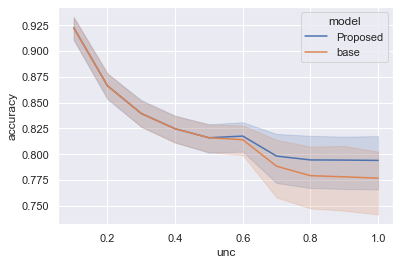

In [156]:
# seaborn による出力
import pandas as pd
import os
import seaborn as sns
# ファイルの読み込み
folder_path = os.path.join(
    os.environ["sleep"], "tmp_outputs", "enn_outputs_4stage_accuracy"
)
filepath = os.path.join(folder_path, "output_trimmed.csv")
df = pd.read_csv(filepath)
sns.set_theme(style="darkgrid")

# Load an example dataset with long-form data
fmri = sns.load_dataset("fmri")

# Plot the responses for different events and regions
line_plot = sns.lineplot(x="unc", y="accuracy", hue="model", data=df)
figure = line_plot.get_figure()
# 保存先を指定
save_path = "tmp.png"
figure.savefig(save_path)

In [52]:
minutes = [i for i in range(60, 250, 10)]
print(minutes)

[60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240]


In [18]:
import pandas as pd
filepath = "tmp.csv"
df = pd.read_csv(filepath, usecols=["date id"])

In [19]:
# jsonへの書き出し
import os, json, sys
with open("model_id.json") as f:
    loaded_dict = json.load(f)

In [20]:
# jsonオブジェクトへの値の書き込み(ファイルにはまだ書き込んでない)
loaded_dict["enn"]["spectrum"]["middle"]["stride_480"]["kernel_512"]["no_cleansing"] = list(df["date id"])

In [21]:
loaded_dict["enn"]["spectrum"]["middle"]["stride_480"]["kernel_512"]["no_cleansing"]

['20211010-150603',
 '20211010-153351',
 '20211010-160134',
 '20211010-162914',
 '20211010-165658',
 '20211010-172455',
 '20211010-175246',
 '20211010-182049',
 '20211010-184828',
 '20211010-191612',
 '20211010-194406',
 '20211010-201147',
 '20211010-203939',
 '20211010-210727',
 '20211010-213534',
 '20211010-220339',
 '20211010-223130',
 '20211010-225941',
 '20211010-232749',
 '20211010-235536',
 '20211011-002353',
 '20211011-005200',
 '20211011-012004',
 '20211011-014824',
 '20211011-021620',
 '20211011-024429',
 '20211011-031239',
 '20211011-034045',
 '20211011-040844',
 '20211011-043636',
 '20211011-050420',
 '20211011-053223',
 '20211011-060018',
 '20211011-062820',
 '20211011-065617',
 '20211011-072421',
 '20211011-075221',
 '20211011-082027',
 '20211011-084832',
 '20211011-091620',
 '20211011-094425',
 '20211011-101226',
 '20211011-104032',
 '20211011-110834',
 '20211011-113639',
 '20211011-120429',
 '20211011-123229',
 '20211011-130030',
 '20211011-132848',
 '20211011-135706',


In [22]:
# 書き込み(jsonファイルへの書き出し)
with open("model_id.json", "w") as f:
    json.dump(loaded_dict, f, indent=4)